## Paddy Disease Classification

**meta_train.csv** - The training set

- `image_id` - Unique image identifier corresponds to image file names (.jpg) found in the train_images directory.
- `label` - Type of paddy disease, also the target class. There are ten categories, including the normal leaf.
- `variety` - The name of the paddy variety.
- `age` - Age of the paddy in days.

**train_images** - This directory contains 10,407 training images stored under different sub-directories corresponding to ten target classes. Filename corresponds to the `image_id` column of `meta_train.csv`.

**test_images** - This directory contains 3,469 test set images.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import imagehash
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model, layers, models

# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
model_name = 'clf-cnn'
dir_train_dataset = 'data/train/'
dir_test_dataset = 'data/test/'
dir_log = 'log/' + model_name
dir_models = 'models/'
path_model = dir_models + model_name


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.19.0
GPU is NOT AVAILABLE


In [2]:
def load(from_dir: str) -> pd.DataFrame:
    """
    Load a directory of paddy leaf disease images (e.g., data/train or data/test) into a DataFrame.

    Each subfolder is assumed to be a disease class label.

    Returns a DataFrame with:
    - image_path: Relative to from_dir
    - file_type: Extension
    - width, height: Image dimensions
    - ratio: width / height
    - mode: Image mode (e.g. RGB)
    - bands: Space-separated bands (e.g. "R G B")
    - transparency: Whether the image has an alpha channel
    - animated: Whether the image is an animated image (like GIF)
    - label: The disease class (from the folder name)
    """

    from_dir = Path(from_dir)
    data = {
        'image_path': [],
        'file_type': [],
        'width': [],
        'height': [],
        'ratio': [],
        'mode': [],
        'bands': [],
        'transparency': [],
        'animated': [],
        'label': []
    }

    for label_dir in from_dir.iterdir():
        if not label_dir.is_dir():
            continue

        for img_file in label_dir.iterdir():
            try:
                with Image.open(img_file) as im:
                    data['image_path'].append(str(img_file.relative_to(from_dir)))
                    data['file_type'].append(img_file.suffix.lstrip('.').lower())
                    data['width'].append(im.width)
                    data['height'].append(im.height)
                    data['ratio'].append(im.width / im.height)
                    data['mode'].append(im.mode)
                    data['bands'].append(' '.join(im.getbands()))
                    data['transparency'].append(
                        im.mode in ('RGBA', 'RGBa', 'LA', 'La', 'PA') or
                        (im.mode == 'P' and 'transparency' in im.info)
                    )
                    data['animated'].append(getattr(im, 'is_animated', False))
                    data['label'].append(label_dir.name)
            except Exception as e:
                print(f"Failed to process {img_file}: {e}")

    return pd.DataFrame(data)

In [3]:
df_train = load(dir_train_dataset)

In [4]:
df_train.head()

,image_path,file_type,width,height,ratio,mode,bands,transparency,animated,label
0,bacterial_leaf_blight\100023_17000f.jpg,jpg,256,256,1.0,RGB,R G B,False,False,bacterial_leaf_blight
1,bacterial_leaf_blight\100023_42a2e7.jpg,jpg,256,256,1.0,RGB,R G B,False,False,bacterial_leaf_blight
2,bacterial_leaf_blight\100023_44e7fe.jpg,jpg,256,256,1.0,RGB,R G B,False,False,bacterial_leaf_blight
3,bacterial_leaf_blight\100023_96e7a4.jpg,jpg,256,256,1.0,RGB,R G B,False,False,bacterial_leaf_blight
4,bacterial_leaf_blight\100023_d498d7.jpg,jpg,256,256,1.0,RGB,R G B,False,False,bacterial_leaf_blight


In [5]:
df_train.describe()

,width,height,ratio
count,14112.0,14112.0,14112.0
mean,256.0,256.0,1.0
std,0.0,0.0,0.0
min,256.0,256.0,1.0
25%,256.0,256.0,1.0
50%,256.0,256.0,1.0
75%,256.0,256.0,1.0
max,256.0,256.0,1.0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14112 entries, 0 to 14111
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_path    14112 non-null  object 
 1   file_type     14112 non-null  object 
 2   width         14112 non-null  int64  
 3   height        14112 non-null  int64  
 4   ratio         14112 non-null  float64
 5   mode          14112 non-null  object 
 6   bands         14112 non-null  object 
 7   transparency  14112 non-null  bool   
 8   animated      14112 non-null  bool   
 9   label         14112 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 909.7+ KB


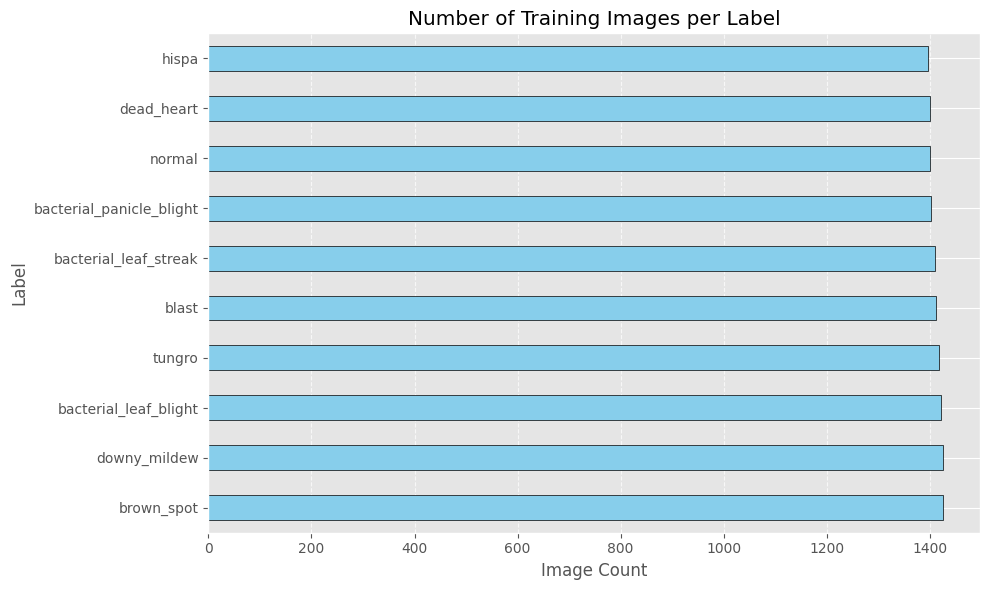

In [7]:
label_counts = df_train['label'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='barh', color='skyblue', edgecolor='black')

plt.title('Number of Training Images per Label')
plt.xlabel('Image Count')
plt.ylabel('Label')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
train, val = train_test_split(df_train, shuffle=True, test_size=0.2, random_state=42)  # 80/20/20 - train/val/test

print(f'Train data: {train.shape[0]} samples, Validation Data: {val.shape[0]} samples.')

Train data: 11289 samples, Validation Data: 2823 samples.


In [9]:
TARGET_IMG_SIZE = 256

In [10]:
# Model Parameters
BATCH_SIZE = 64
OUTPUT_CLASSES = 10  # One-hot encoded: 10 different classes

# Training Parameters
EPOCHS = 20
LEARNING_RATE = 0.0001
MOMENTUM = 0.9

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=[256,256,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalMaxPooling2D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
], name=model_name)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE),loss="categorical_crossentropy",
    metrics=['categorical_accuracy'])

D:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "clf-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,522 (1.62 MB)

 Trainable params: 423,562 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
train['label'] = train['label'].astype('str')
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=dir_train_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val['label'] = val['label'].astype('str')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=dir_train_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 11289 validated image filenames belonging to 10 classes.
Found 2823 validated image filenames belonging to 10 classes.


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_log, write_graph=False)
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
)

D:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.1579 - loss: 4.4692

D:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 1111s 6s/step - categorical_accuracy: 0.1582 - loss: 4.4605 - val_categorical_accuracy: 0.1010 - val_loss: 2.4300
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1091s 6s/step - categorical_accuracy: 0.3036 - loss: 1.9877 - val_categorical_accuracy: 0.1651 - val_loss: 2.3620
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1087s 6s/step - categorical_accuracy: 0.3615 - loss: 1.8332 - val_categorical_accuracy: 0.3677 - val_loss: 1.8462
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1083s 6s/step - categorical_accuracy: 0.4147 - loss: 1.7074 - val_categorical_accuracy: 0.4580 - val_loss: 1.5964
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1089s 6s/step - categorical_accuracy: 0.4533 - loss: 1.5873 - val_categorical_accuracy: 0.5572 - val_loss: 1.3437
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1081s 6s/step - categorical_accuracy: 0.4867 - loss: 1.4884 - val_categorical_accuracy: 0.5551 - val_loss: 1.3479
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1149s 6s/step - categorical_accuracy: 0.5405 - 

In [ ]:
def plot_learning_curve(
        train_loss, val_loss, train_metric, val_metric,
        to_file: str = None
) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_loss, 'r--')
    ax[0].plot(val_loss, 'b--')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(['train', 'val'])

    ax[1].plot(train_metric, 'r--')
    ax[1].plot(val_metric, 'b--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].axhline(y=0.125, c='g', alpha=0.5)  # Random probability - naive classifier
    ax[1].legend(['train', 'val', 'random baseline'])

    fig.tight_layout()
    plt.show()
    if to_file is not None:
        fig.savefig(to_file)

In [ ]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
)

In [ ]:
test = load(dir_test_dataset)
test['label'] = test['label'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=dir_test_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

In [ ]:
def visualize_32predictions(
    model: Model,
    test_generator,
    to_file: str = None
) -> None:
    fig, ax = plt.subplots(8, 4, figsize=(20, 20))
    ax = ax.ravel()

    class_labels = list(test_generator.class_indices.keys())
    sample_indices = random.sample(range(len(test_generator.filenames)), 32)

    for i, idx in enumerate(sample_indices):
        img_path = test_generator.filepaths[idx]

        # Load the image manually
        img = image.load_img(img_path, target_size=test_generator.target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # normalize if needed (depends on your ImageDataGenerator)

        # Predict
        pred = model.predict(img_array, verbose=0)

        predicted_index = np.argmax(pred)
        predicted_label = class_labels[predicted_index]

        true_index = test_generator.classes[idx]
        true_label = class_labels[true_index]

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(
            f'Ground Truth: {true_label}\nPrediction: {predicted_label}',
            fontsize=8
        )
        ax[i].text(
            0.5, 1.15, f'{"CORRECT" if predicted_index == true_index else "INCORRECT"}',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax[i].transAxes,
            fontsize=8,
            color='green' if predicted_index == true_index else 'red',
            weight='bold'
        )

    plt.tight_layout()
    plt.show()

    if to_file:
        fig.savefig(to_file, bbox_inches='tight')

In [ ]:
visualize_32predictions(model, test_generator)

In [ ]:
# Evaluate on training set
train_loss, train_acc = model.evaluate(train_generator, steps=len(train_generator), verbose=1)
print(f"Train Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

In [ ]:
# Evaluate on testing set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")